In [5]:
import pyspark as ps
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [42]:
budget_pd = pd.read_csv('../data/Combined Spending Data.csv')

In [26]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('budget_data')
         .getOrCreate()
        )
sc = spark.sparkContext

In [27]:
spark_population = spark.read.csv('../data/population_by_county_2003_to_2017.csv',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)

In [28]:
spark_population.createOrReplaceTempView('population_tempview')

In [29]:
query = '''
select `Year`, `County`, `Population`
from population_tempview
WHERE `County` != 'None'
'''

population_sql = spark.sql(query)
population_pd = population_sql.toPandas()
population_pd

,Year,County,Population
0,2003,Alameda,1467892
1,2003,Alpine,1248
2,2003,Amador,36656
3,2003,Butte,209389
4,2003,Calaveras,42651
...,...,...,...
865,2017,Tulare,470716
866,2017,Tuolumne,54725
867,2017,Ventura,855910
868,2017,Yolo,218673


In [44]:
budget_per_capita_pd = budget_pd.join(population_pd)
budget_per_capita_pd

,Entity Name,Fiscal Year,Police Protection_Total,Mental Health_Total,Substance Abuse Services_Total,Year,County,Population
0,Alameda,2003,67620724,162111429.0,28910904.0,2003,Alameda,1467892
1,Alpine,2003,1610553,148701.0,500356.0,2003,Alpine,1248
2,Amador,2003,5715469,1885165.0,849770.0,2003,Amador,36656
3,Butte,2003,11450959,28935820.0,4019764.0,2003,Butte,209389
4,Calaveras,2003,5672737,2007571.0,875481.0,2003,Calaveras,42651
...,...,...,...,...,...,...,...,...
865,Tulare,2017,44952206,49908459.0,10258973.0,2017,Tulare,470716
866,Tuolumne,2017,14401180,8863405.0,NaN,2017,Tuolumne,54725
867,Ventura,2017,167615812,58160419.0,22870488.0,2017,Ventura,855910
868,Yolo,2017,12824122,28356943.0,1835271.0,2017,Yolo,218673


In [50]:
#budget_per_capita_pd.drop('County', axis=1, inplace=True)
#budget_per_capita_pd.drop('Year', axis=1, inplace=True)
#budget_per_capita_pd.rename(columns = {'Entity Name':'County', 'Fiscal Year':'Year'}, inplace=True)
#budget_per_capita_pd['Police Spending Per Capita'] = budget_per_capita_pd['Police Protection_Total'] / budget_per_capita_pd['Population']
#budget_per_capita_pd['Mental Health Spending Per Capita'] = budget_per_capita_pd['Mental Health_Total'] / budget_per_capita_pd['Population']
#budget_per_capita_pd['Substance Abuse Services Spending Per Capita'] = budget_per_capita_pd['Substance Abuse Services_Total'] / budget_per_capita_pd['Population']

In [51]:
budget_per_capita_pd

,County,Year,Police Protection_Total,Mental Health_Total,Substance Abuse Services_Total,Population,Police Spending Per Capita,Mental Health Spending Per Capita,Substance Abuse Services Spending Per Capita
0,Alameda,2003,67620724,162111429.0,28910904.0,1467892,46.066553,110.438254,19.695525
1,Alpine,2003,1610553,148701.0,500356.0,1248,1290.507212,119.151442,400.926282
2,Amador,2003,5715469,1885165.0,849770.0,36656,155.921786,51.428552,23.182289
3,Butte,2003,11450959,28935820.0,4019764.0,209389,54.687491,138.191691,19.197589
4,Calaveras,2003,5672737,2007571.0,875481.0,42651,133.003611,47.069729,20.526623
...,...,...,...,...,...,...,...,...,...
865,Tulare,2017,44952206,49908459.0,10258973.0,470716,95.497510,106.026689,21.794400
866,Tuolumne,2017,14401180,8863405.0,NaN,54725,263.155413,161.962631,NaN
867,Ventura,2017,167615812,58160419.0,22870488.0,855910,195.833454,67.951559,26.720669
868,Yolo,2017,12824122,28356943.0,1835271.0,218673,58.645201,129.677386,8.392765


In [52]:
police_dict = {}
for county in budget_per_capita_pd['County'].unique():
    police_dict[county] = list(budget_per_capita_pd[budget_per_capita_pd.County==county]['Police Spending Per Capita'].values)

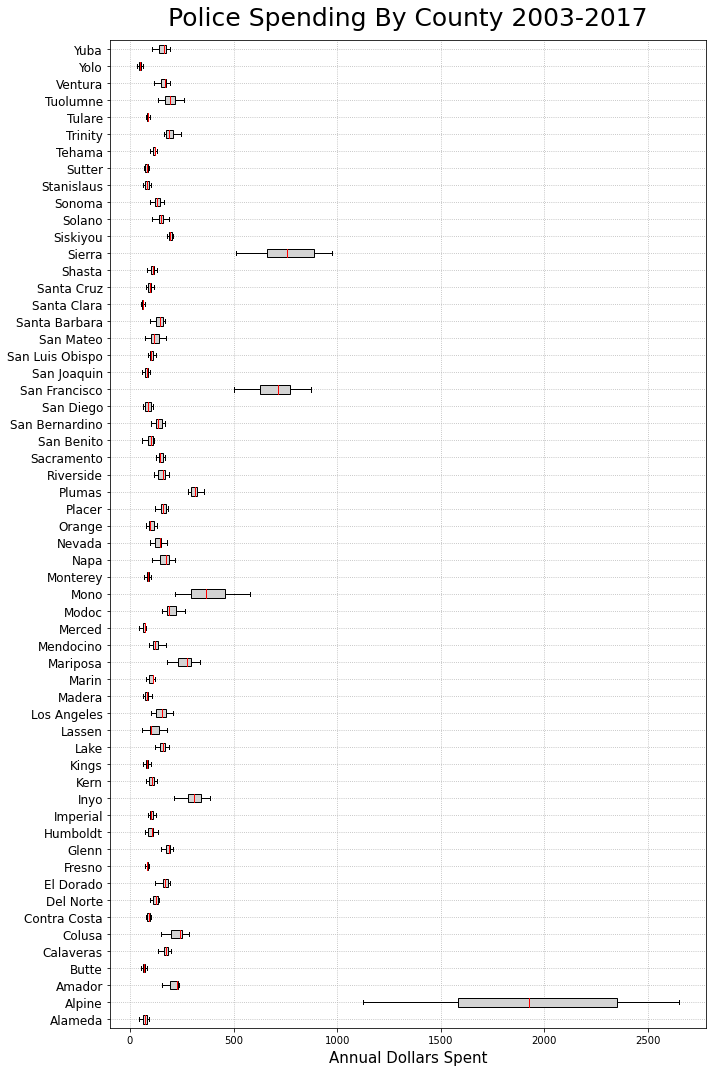

In [53]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.boxplot(police_dict.values(), vert=False, showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightgrey', color='black'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='red', markeredgecolor='red'),
            medianprops=dict(color='red'))

ax.set_yticklabels(police_dict.keys(), fontsize=12)
ax.set_xlabel('Annual Dollars Spent', fontsize=15, labelpad=5)
ax.set_title('Police Spending By County 2003-2017', fontsize=25, pad=15)
ax.grid(linestyle=':')
fig.tight_layout()